In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!tar -xzf ./drive/MyDrive/ece_ml/miniImagenet.tgz -C ./

Mounted at /content/drive


In [ ]:
import torchvision

dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)

image, label = dataset[0]
print(type(image))  # torch.Tensor
print(type(label))  # int

100%|██████████| 9464212/9464212 [00:00<00:00, 66165150.84it/s]


Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py
<class 'torch.Tensor'>
<class 'int'>


In [ ]:
!rm -rf ./train

In [ ]:
cifar_train = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=torchvision.transforms.ToTensor())
cifar_test = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=False, transform=torchvision.transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 62874865.78it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [ ]:
mergeDataSet = torch.utils.data.ConcatDataset([cifar_train, cifar_test])
newTrainSet , newTestSet, newValSet = torch.utils.data.random_split(mergeDataSet, [0.4, 0.4, 0.2], generator=torch.Generator().manual_seed(423))

In [ ]:
print(getSize(newTrainSet))
print(getSize(newTestSet))
print(getSize(newValSet))
# for i, l in mnist_testset:
#   print(l)
# for i in newTrainSet:
#   print(i[0].shape)

42000
12000
6000


In [ ]:
def getSize(dataSet):
  ct = 0
  for i in dataSet:
    ct += 1
  return ct

In [ ]:
train_loader = DataLoader(newTrainSet, batch_size=10, shuffle=True)

val_loader = DataLoader(newTestSet, batch_size=len(newValSet), shuffle=True)
val_train_loader = DataLoader(newTestSet, batch_size=20, shuffle=True)

test_loader = DataLoader(newValSet, batch_size=40, shuffle=True)

In [ ]:
for i in train_loader:
  print(i[0].shape)
  break
print(len(train_loader))

torch.Size([25, 1, 28, 28])
3360


In [ ]:
import copy
from collections import OrderedDict
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import torch.nn as nn
import numpy as np

In [ ]:
def accuracy(output, target):
  ct = 0
  for i in range(len(target)):
    temp = output[i].argmax()
    if temp == target[i]:
      ct += 1
  return float(ct) * 100 / len(target)

def andry_pre(g):
  c = (g.abs() >= np.exp(-10)).to(torch.float32)
  x = c - 1 + torch.log(g.abs() + 2e-10) * c / 10
  y = c * torch.sign(g) + (1 - c) * np.exp(10) * x
  return torch.stack((x, y), 1)

In [ ]:
class Learner(nn.Module):

  def __init__(self, image_size, n_classes):
    super(Learner, self).__init__()
    self.model = nn.ModuleDict(
        {'features': 
         nn.Sequential(OrderedDict([
      ('conv1', nn.Conv2d(3, 32, 3, padding=1)),
      ('norm1', nn.BatchNorm2d(32, 0.001, 0.95)),
      ('relu1', nn.ReLU(inplace=False)),
      ('pool1', nn.MaxPool2d(2)),

      ('conv2', nn.Conv2d(32, 32, 3, padding=1)),
      ('norm2', nn.BatchNorm2d(32, 0.001, 0.95)),
      ('relu2', nn.ReLU(inplace=False)),
      ('pool2', nn.MaxPool2d(2)),

      ('conv3', nn.Conv2d(32, 32, 3, padding=1)),
      ('norm3', nn.BatchNorm2d(32, 0.001, 0.95)),
      ('relu3', nn.ReLU(inplace=False)),
      ('pool3', nn.MaxPool2d(2)),

      ('conv4', nn.Conv2d(32, 32, 3, padding=1)),
      ('norm4', nn.BatchNorm2d(32, 0.001, 0.95)),
      ('relu4', nn.ReLU(inplace=False)),
      ('pool4', nn.MaxPool2d(2))]))
    })

    clr_in = image_size // 2**4
    self.model.update({'cls': nn.Linear(32 * clr_in * clr_in, n_classes)})
    self.loss = nn.CrossEntropyLoss()

  def forward(self, x):
    x = self.model.features(x)
    x = torch.reshape(x, [x.size(0), -1])
    outputs = self.model.cls(x)
    return outputs

  def get_param(self):
    return torch.cat([p.view(-1) for p in self.model.parameters()], 0)

  def copy_param(self, cI):
    idx = 0
    for p in self.model.parameters():
      plen = p.view(-1).size(0)
      p.data.copy_(cI[idx: idx+plen].view_as(p))
      idx += plen

  def transfer_params(self, model, cI):
    self.load_state_dict(model.state_dict())
    idx = 0
    for m in self.model.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
        wlen = m._parameters['weight'].view(-1).size(0)
        m._parameters['weight'] = cI[idx: idx+wlen].view_as(m._parameters['weight']).clone()
        idx += wlen
        if m._parameters['bias'] is not None:
          blen = m._parameters['bias'].view(-1).size(0)
          m._parameters['bias'] = cI[idx: idx+blen].view_as(m._parameters['bias']).clone()
          idx += blen

  def drop_to_default(self):
    for m in self.modules():
      if type(m) == nn.BatchNorm2d:
        m.reset_running_stats()

In [ ]:
import torch.nn.functional as F

def semi_loss(pred, label, un_pred=None, t=0.8):
  loss = F.cross_entropy(pred, label)
  un_loss = 0
  if un_pred is not None:
    un_p = F.softmax(un_pred, dim=1)
    avg_p = torch.mean(un_p, dim=0)
    un_loss = torch.mean(torch.sum(-avg_p * torch.log(un_p + 1e-6), dim=1))

  # combine the two losses
  loss = loss + t * un_loss
  return loss

class MetaLSTMCell(nn.Module):
  def __init__(self, n_learner_params):
    super(MetaLSTMCell, self).__init__()
    self.n_learner_params = n_learner_params
    self.WF = nn.Parameter(torch.Tensor(22, 1))
    self.WI = nn.Parameter(torch.Tensor(22, 1))
    self.cI = nn.Parameter(torch.Tensor(n_learner_params, 1))
    self.bI = nn.Parameter(torch.Tensor(1, 1))
    self.bF = nn.Parameter(torch.Tensor(1, 1))
    self.reset_parameters()

  def reset_parameters(self):
    for weight in self.parameters():
      nn.init.uniform_(weight, -0.01, 0.01)
      nn.init.uniform_(self.bF, 4, 6)
      nn.init.uniform_(self.bI, -5, -4)

  def init_cI(self, flat_params):
    self.cI.data.copy_(flat_params.unsqueeze(1))

  def forward(self, inputs, hx=None):

    x_all, grad = inputs
    batch, _ = x_all.size()

    if hx is None:
      f_p = torch.zeros((batch, 1)).to(self.WF.device)
      i_p = torch.zeros((batch, 1)).to(self.WI.device)
      c_p = self.cI
      hx = [f_p, i_p, c_p]

    f_p, i_p, c_p = hx
        
    f_next = torch.mm(torch.cat((x_all, c_p, f_p), 1), self.WF) + self.bF.expand_as(f_p)
    i_next = torch.mm(torch.cat((x_all, c_p, i_p), 1), self.WI) + self.bI.expand_as(i_p)
    c_next = torch.sigmoid(f_next).mul(c_p) - torch.sigmoid(i_next).mul(grad)
    return c_next, [f_next, i_next, c_next]


class MetaLearner(nn.Module):

  def __init__(self, n_learner_params):
    super(MetaLearner, self).__init__()
    self.lstm = nn.LSTMCell(4, 20)
    self.metalstm = MetaLSTMCell(n_learner_params=n_learner_params)

  def forward(self, inputs, hs=None):
    loss, grad_prep, grad = inputs
    loss = loss.expand_as(grad_prep)
    inputs = torch.cat((loss, grad_prep), 1)   # [n_learner_params, 4]
    if hs is None:
      hs = [None, None]
    lstmhx, lstmcx = self.lstm(inputs, hs[0])
    flat_learner_unsqzd, metalstm_hs = self.metalstm([lstmhx, grad], hs[1])
    return flat_learner_unsqzd.squeeze(), [(lstmhx, lstmcx), metalstm_hs]

In [ ]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

def meta_test(train_loader, val_loader, cnn,cnn_eval, metalearner):
  transform = T.ToPILImage()

  train_iter = iter(train_loader)
  train_data, train_lable = next(train_iter)
  train_data = train_data.to(torch.device('cuda'))
  train_lable = train_lable.to(torch.device('cuda'))
  print(train_data.shape)

  val_iter = iter(val_loader)
  val_data, val_label = next(val_iter)
  val_data = val_data.to(torch.device('cuda'))
  val_label = val_label.to(torch.device('cuda'))

  cnn.drop_to_default()
  cnn_eval.drop_to_default()
  cnn.train()
  cnn_eval.eval()
  cI = train_learner(cnn, metalearner, train_data, train_lable)
  cnn_eval.transfer_params(cnn, cI)
  output = cnn_eval(val_data)

  img = transform(val_data[0])
  img.show()
  print(output[0].argmax())
  print(val_label[0])
  # img = transform(output[0])
  # img.show()
  acc = accuracy(output, val_label)
  return acc


def train_learner(cnn, metalearner, train_input, train_target):
  cI = metalearner.metalstm.cI.data
  hs = [None]
  for _ in range(12):
    cnn.copy_param(cI)
    output = cnn(train_input)
    loss = cnn.loss(output, train_target)
    cnn.zero_grad()
    loss.backward()
    grad = torch.cat([p.grad.data.view(-1) / 10 for p in cnn.parameters()], 0)
    grad_prep = andry_pre(grad)  # [n_learner_params, 2]
    loss_prep = andry_pre(loss.data.unsqueeze(0)) # [1, 2]
    metalearner_input = [loss_prep, grad_prep, grad.unsqueeze(1)]
    cI, h = metalearner(metalearner_input, hs[-1])
    hs.append(h)
  return cI

cnn = Learner(32, 0.001, 0.95, 10).to(torch.device('cuda'))
cnn_eval = Learner(32, 0.001, 0.95, 10).to(torch.device('cuda'))
metalearner = MetaLearner(cnn.get_param().size(0)).to(torch.device('cuda'))
metalearner.metalstm.init_cI(cnn.get_param())


optim = torch.optim.Adam(metalearner.parameters(), 0.001)

train_acc_list = []
valid_acc_list = []
best_acc = float(0.0)
print(best_acc)
# Meta-training
test = iter(test_loader)
ct = 0
for eps, (train_input, train_target) in enumerate(train_loader):
  # print(train_target)
  try:
    test_input, test_target = next(test)
  except StopIteration:
    test = iter(test_loader)
    test_input, test_target = next(test)
  test_input = test_input.to(torch.device('cuda'))
  test_target = test_target.to(torch.device('cuda'))
  train_input = train_input.to(torch.device('cuda'))
  train_target = train_target.to(torch.device('cuda'))
  cnn.drop_to_default()
  cnn_eval.drop_to_default()
  cnn.train()
  cnn_eval.train()
  cI = train_learner(cnn, metalearner, train_input, train_target)
  cnn_eval.transfer_params(cnn, cI)
  output = cnn_eval(test_input)
  loss = cnn_eval.loss(output, test_target)
  optim.zero_grad()
  loss.backward()
  nn.utils.clip_grad_norm_(metalearner.parameters(), 0.25)
  optim.step()
  acc = accuracy(output, test_target)
  train_acc_list.append(acc)
  if eps % 100 == 0 and eps != 0:
    acc = meta_test(val_train_loader, val_loader, cnn,cnn_eval, metalearner)
    valid_acc_list.append([acc] * 100)
    if float(acc) > float(best_acc):
      best_acc = acc
      print("Epoch " + str(eps) +": * Best accuracy so far :" + str(acc))
    else:
      print("Epoch " + str(eps) + ": " + str(acc))
# logger.loginfo("Done")

print('test learner')
output = cnn(test_input)
acc = accuracy(output, test_target)
print(acc)

In [ ]:
mergeDataSet = torch.utils.data.ConcatDataset([cifar_train, cifar_test])
newTrainSet , newTestSet, newValSet = torch.utils.data.random_split(mergeDataSet, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(423))

train_loader = DataLoader(newTrainSet, batch_size=10, shuffle=True)

val_loader = DataLoader(newTestSet, batch_size=len(newValSet), shuffle=True)
val_train_loader = DataLoader(newTestSet, batch_size=20, shuffle=True)

test_loader = DataLoader(newValSet, batch_size=40, shuffle=True)

In [ ]:
learner_w_grad = copy.deepcopy(baseline)
output = learner_w_grad(test_input)
acc = accuracy(output, test_target)
print(acc)

17.5


torch.Size([20, 3, 32, 32])


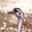

tensor(7, device='cuda:0')
tensor(2, device='cuda:0')
50.916666666666664


In [ ]:
print(meta_test(val_train_loader, val_loader, cnn, metalearner))

In [ ]:
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

# Define superclass labels and mapping
superclasses = ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
superclass_mapping = {k: v for v, k in enumerate(superclasses)}
clsToSuper = {"beaver": "aquatic mammals", "dolphin" : "aquatic mammals", "otter": "aquatic mammals", "seal" : "aquatic mammals", "whale" : "aquatic_mammals",
              	"aquarium_fish" : 'fish', "flatfish": 'fish', "ray": 'fish', "shark": 'fish', "trout": 'fish',
              "orchid": 'flowers', "poppy": 'flowers', "rose": 'flowers', "sunflower": 'flowers', "tulip": 'flowers',
              	"bottle": 'food_containers', "bowl": 'food_containers', "can": 'food_containers', "cup": 'food_containers', "plate": 'food_containers',
              "apple":'fruit_and_vegetables', "mushroom": 'fruit_and_vegetables', "orange": 'fruit_and_vegetables', "pear": 'fruit_and_vegetables', "sweet_pepper": 'fruit_and_vegetables',
              "clock": 'household_electrical_devices', "keyboard": 'household_electrical_devices', "lamp": 'household_electrical_devices', "telephone": 'household_electrical_devices', "television": 'household_electrical_devices',
              	"bed": 'household_furniture', "chair": 'household_furniture', "couch": 'household_furniture', "table": 'household_furniture', "wardrobe": 'household_furniture',
              	"bee": 'insects', "beetle": 'insects', "butterfly": 'insects', "caterpillar": 'insects', "cockroach": 'insects',
              	"bear": 'large_carnivores', "leopard": 'large_carnivores', "lion": 'large_carnivores', "tiger": 'large_carnivores', "wolf": 'large_carnivores',
              "bridge": 'large_man-made_outdoor_things', "castle": 'large_man-made_outdoor_things', "house": 'large_man-made_outdoor_things', "road": 'large_man-made_outdoor_things', "skyscraper": 'large_man-made_outdoor_things',
              "cloud": 'large_natural_outdoor_scenes', "forest": 'large_natural_outdoor_scenes', "mountain": 'large_natural_outdoor_scenes', "plain": 'large_natural_outdoor_scenes', "sea": 'large_natural_outdoor_scenes',
              "camel": 'large_omnivores_and_herbivores', "cattle": 'large_omnivores_and_herbivores', "chimpanzee": 'large_omnivores_and_herbivores', "elephant": 'large_omnivores_and_herbivores', "kangaroo": 'large_omnivores_and_herbivores',
              	"fox":'medium_mammals', "porcupine":'medium_mammals', "possum":'medium_mammals', "raccoon":'medium_mammals', "skunk":'medium_mammals',
              	"crab":'non-insect_invertebrates', "lobster":'non-insect_invertebrates', "snail": 'non-insect_invertebrates', "spider": 'non-insect_invertebrates', "worm":'non-insect_invertebrates',
              "baby":'people', "boy":'people', "girl":'people', "man":'people', "woman":'people',
              "crocodile":'reptiles', "dinosaur":'reptiles', "lizard":'reptiles', "snake":'reptiles', "turtle":'reptiles',
              "hamster":'small_mammals', "mouse":'small_mammals', "rabbit":'small_mammals', "shrew":'small_mammals', "squirrel":'small_mammals',
              	"maple_tree":'trees', "oak_tree":'trees', "palm_tree":'trees', "pine_tree":'trees', "willow_tree":'trees',
              	"bicycle":'vehicles_1', "bus":'vehicles_1', "motorcycle":'vehicles_1', "pickup_truck":'vehicles_1', "train":'vehicles_1',
              	"lawn_mower":'vehicles_2', "rocket":'vehicles_2', "streetcar":'vehicles_2', "tank":'vehicles_2', "tractor":'vehicles_2'}
clss = trainset.classes
print(trainset[0][0].shape)
class SuperclassDataset(Dataset):
    def __init__(self, dataset, superclass1, superclass2):
        self.dataset = dataset
        self.indices = []
        for i in range(0, len(dataset)):
          temp = clsToSuper[clss[dataset[i][1]]]
          if temp == superclass1 or temp == superclass2:
            self.indices.append(i)
    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)
class testData(Dataset):
    def __init__(self, dataset, cls):
        print(cls)
        self.dataset = dataset
        self.indices = []
        for i in range(0, len(dataset)):
          temp = dataset[i][1]
          if temp == cls:
            self.indices.append(i)
    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

class validData(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = []
        for i in range(0, len(dataset)):
          temp = dataset[i][1]
          if temp < 10:
            self.indices.append(i)
    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)
# Define dataloaders for each superclass
trainloaders = {}
testloaders = {}
test_list = []
for i in range(0, 5):
  test_list.append((superclasses[2 * i], superclasses[2*i + 1]))
total_acc = 0

100%|██████████| 169001437/169001437 [00:02<00:00, 78898564.59it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
torch.Size([3, 32, 32])


In [ ]:
cifar_loader = []
valid_laoder = DataLoader(validData(trainset), batch_size=len(trainset), shuffle=True)
for i in range(0, 10):
  print(trainset)
  cifar_loader.append(DataLoader(testData(trainset, i), batch_size=1, shuffle=True))

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
0
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
1
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
2
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
3
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
4
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
5
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
6
Dataset CIFAR100
    Number of dat

In [ ]:
train_data = []
train_label = []
ul_data = []
test_data = []
test_label = []
ct = 0
for i in random.sample(cifar_loader, 10):
  data, label = next(iter(i))
  train_data.append(i)
  train_label.append(ct)
  ct += 1
  data, label = next(iter(i))
  ul_data.append(data)
  data, label = next(iter(i))
  test_data.append(data)
  test_label.append(label)
train_data = torch.concat(train_data, 0)
train_label = torch.tensor(train_label)
ul_data = torch.concat(ul_data, 0)
test_data = torch.concat(test_data, 0)
test_label = torch.concat(test_label, 0)

In [ ]:
cifar_train_data = []
cifar_train_label = []
cifar_iter = []
for i in range(0, 10):
  cifar_iter.append(iter(cifar_loader[i]))
  data, label = next(cifar_iter[i])
  cifar_train_data.append(data)
  cifar_train_label.append(label)
cifar_train_data = torch.concat(cifar_train_data, 0)
cifar_train_label = torch.concat(cifar_train_label, 0)
print(cifar_train_data.shape)
print(cifar_train_label)
cifar_train_un_data = []
for i in range(0, 10):
  data, _ = next(cifar_iter[i])
  cifar_train_un_data.append(data)
cifar_train_un_data = torch.concat(cifar_train_un_data, 0)

# valid_laoder = DataLoader(validData(trainset), batch_size=len(trainset), shuffle=True)
valid_data, valid_label = next(iter(valid_laoder))
print(valid_data.shape)

torch.Size([10, 3, 32, 32])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([5000, 3, 32, 32])


In [ ]:
for x, y in train_loader:
  print(y)

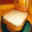

tensor(6, device='cuda:0')
tensor(5, device='cuda:0')
25.0


In [ ]:
print(meta_test(train_loader, train_loader, learner_w_grad, metalearner))

torch.Size([10, 3, 32, 32])


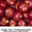

tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
10.56


In [ ]:
def meta_valid(train_data, train_lable, unl_data, val_data, val_label, learner, metalearner):
  transform = T.ToPILImage()
  train_data = train_data.to(torch.device('cuda'))
  train_lable = train_lable.to(torch.device('cuda'))
  unl_data = unl_data.to(torch.device('cuda'))
  val_data = val_data.to(torch.device('cuda'))
  val_label = val_label.to(torch.device('cuda'))
  print(train_data.shape)
  learner.drop_to_default()
  learner.train()
  cI = train_learner(learner, metalearner, train_data, unl_data, train_lable)
  learner.copy_param(cI)
  output = learner(val_data)

  img = transform(train_data[0])
  img.show()
  print(output[0].argmax())
  print(train_lable[0])
  # img = transform(output[0])
  # img.show()
  acc = accuracy(output, val_label)
  return acc
print(meta_valid(cifar_train_data, cifar_train_label, cifar_train_un_data, valid_data, valid_label, learner_w_grad, metalearner))

In [ ]:
train_loader = DataLoader(cifar_train, batch_size=100, shuffle=True)

val_loader = DataLoader(newTestSet, batch_size=len(newValSet), shuffle=True)
val_train_loader = DataLoader(newTestSet, batch_size=20, shuffle=True)

test_loader = DataLoader(newValSet, batch_size=40, shuffle=True)

cnn_bench = Learner(32, 0.001, 0.95, 10).to(torch.device('cuda'))
optim1 = torch.optim.Adam(cnn_bench.parameters(), 0.001)
test = iter(test_loader)
cnn_bench.train()
for eps, (train_input, train_target) in enumerate(train_loader):
  
  train_input = train_input.to(torch.device('cuda'))
  train_target = train_target.to(torch.device('cuda'))
  

  output = cnn_bench(train_input)
  loss = cnn_bench.loss(output, train_target)

  loss.backward()
  optim1.step()
  if eps%100 == 0 and eps!=0:
    try:
      test_input, test_target = next(test)
    except StopIteration:
      test = iter(test_loader)
      test_input, test_target = next(test)
    test_input = test_input.to(torch.device('cuda'))
    test_target = test_target.to(torch.device('cuda'))
    test_o = cnn_bench(test_input)
    acc = accuracy(test_o, test_target)
    print(eps)
    print(acc)

100
17.5
200
20.0
300
20.0
400
15.0


In [ ]:
print(clss)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

tensor([67, 73, 73, 91, 67, 73,  1, 32,  1, 67, 32, 67,  1, 32,  1, 67, 32, 32,
        73, 32, 91, 91,  1, 91, 32, 67, 32, 32, 67, 73, 73, 73, 73, 32, 91, 91,
        32, 67, 32, 91, 91, 67,  1, 91, 32, 67, 91, 32, 91, 32,  1, 67, 67, 73,
        32, 67,  1, 91, 73, 91, 67, 73, 32, 67,  1, 67, 73, 91, 91, 73, 67, 32,
         1, 91, 32])


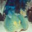

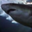

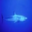

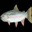

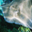

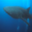

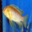

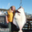

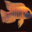

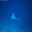

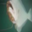

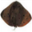

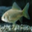

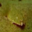

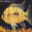

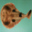

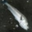

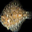

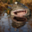

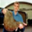

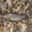

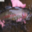

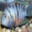

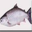

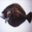

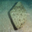

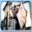

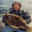

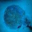

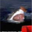

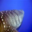

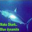

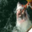

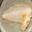

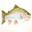

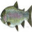

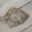

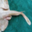

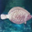

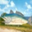

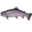

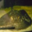

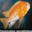

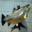

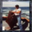

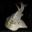

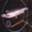

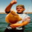

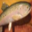

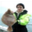

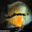

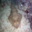

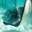

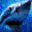

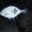

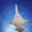

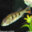

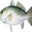

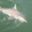

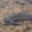

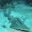

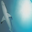

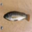

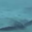

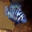

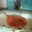

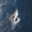

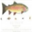

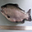

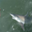

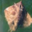

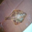

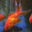

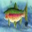

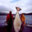

In [ ]:
print(trainloaders['fish'])
it = iter(trainloaders['fish'])
data, label = next(it)
transform = T.ToPILImage()
print(label)
for i in range(0, 75):

  img = transform(data[i])
  img.show()